In [1]:
import time

from dask import delayed
from dask.distributed import Client
import dask.dataframe as dd
import numpy as np
import pandas as pd
import dask

## Data Preparation

In [2]:
_TMP_FILE_NAME = "tmp.csv"
SIZE = 1_000_000

group_index = [1, 2, 3, 4, 5]
groups = group_index * int(SIZE / len(group_index))
numbers = np.random.default_rng(seed=20).random((SIZE,))

numbers = numbers * 100
numbers = numbers.astype("int")

In [3]:
%%time
df_pd = pd.DataFrame(
    data={
        "group": groups,
        "amount": numbers,
    }
)

df_pd.to_csv(path_or_buf=_TMP_FILE_NAME, index=False)

print(df_pd.shape)
df_pd.head(3)

(1000000, 2)
CPU times: user 903 ms, sys: 60.4 ms, total: 963 ms
Wall time: 1.97 s


,group,amount
0,1,28
1,2,46
2,3,12


In [4]:
%%time
df_dd = dd.read_csv(
    urlpath=_TMP_FILE_NAME,
    dtype={
        "group": "int",
        "amount": "int",
    } # specify dtype in case inference failing
)

print(df_dd.shape)
df_dd.head(3)

(Delayed('int-5fdc6e9f-f15f-475e-a1a9-5b698b449f50'), 2)
CPU times: user 101 ms, sys: 42.2 ms, total: 144 ms
Wall time: 205 ms


,group,amount
0,1,28
1,2,46
2,3,12


In [5]:
%%time

df_pd.tail(2)

CPU times: user 87 µs, sys: 31 µs, total: 118 µs
Wall time: 132 µs


,group,amount
999998,4,42
999999,5,42


In [6]:
%%time

df_dd.tail(2)

CPU times: user 79.6 ms, sys: 30.2 ms, total: 110 ms
Wall time: 123 ms


,group,amount
999998,4,42
999999,5,42


## Performance Comparison

Though pandas's DataFrame is faster than Dask's in this case, Dask is more flexible and could fit into memory if data size is gigantic.

In [7]:
%%time
mean_amount = df_pd.groupby("group")["amount"].mean()
mean_amount

CPU times: user 28.8 ms, sys: 2.94 ms, total: 31.7 ms
Wall time: 29.3 ms


group
1    49.657135
2    49.605740
3    49.534620
4    49.571390
5    49.535220
Name: amount, dtype: float64

In [8]:
%%time
mean_amount = df_dd.groupby("group")["amount"].mean()
mean_amount

CPU times: user 20.8 ms, sys: 6.74 ms, total: 27.6 ms
Wall time: 30 ms


Dask Series Structure:
npartitions=1
    float64
        ...
Name: amount, dtype: float64
Dask Name: truediv, 6 tasks

In [9]:
%%time
mean_amount.compute()

CPU times: user 118 ms, sys: 17 ms, total: 135 ms
Wall time: 128 ms


group
1    49.657135
2    49.605740
3    49.534620
4    49.571390
5    49.535220
Name: amount, dtype: float64

### Intermediate Sharing
Some individual computations may related to each other, so it could have performance gain if intermediate results are shared.

In [10]:
grouped = df_dd["amount"]

max_amount = grouped.max()
min_amount = grouped.min()
mean_amount = grouped.mean()

In [11]:
%%time
# without sharing
max_amount.compute(), min_amount.compute(), mean_amount.compute()

CPU times: user 206 ms, sys: 23.8 ms, total: 230 ms
Wall time: 234 ms


(99, 0, 49.580821)

In [12]:
%%time
# without sharing
dask.compute(max_amount, min_amount, mean_amount)

CPU times: user 74.8 ms, sys: 10 ms, total: 84.8 ms
Wall time: 81.9 ms


(99, 0, 49.580821)

### Dask Delayed

In [13]:
def add(x, y=1):
    time.sleep(1)
    return x + y

In [14]:
%%time

for _ in range(2):
    print(add(10))

result = add(10, 10)
result

11
11
CPU times: user 7.4 ms, sys: 2.48 ms, total: 9.87 ms
Wall time: 3.01 s


20

In [15]:
%%time

for _ in range(2):
    print(delayed(add)(10))

result = delayed(add)(10, 10)
result

Delayed('add-9b10766e-16f4-4104-b565-a9889eae6f3a')
Delayed('add-af1c5bbc-ebd2-4500-895e-f56329dc4644')
CPU times: user 720 µs, sys: 0 ns, total: 720 µs
Wall time: 685 µs


Delayed('add-ad2cb7c3-589e-4690-ab2a-4c5a3ed2791c')

In [16]:
%%time

result.compute()

CPU times: user 3.41 ms, sys: 4.33 ms, total: 7.74 ms
Wall time: 1.01 s


20

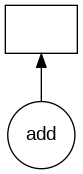

In [17]:
result.visualize()

## Dask Client

In [18]:
client = Client(n_workers=4)

client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 4,Total memory: 1.94 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:38895,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 4
Started: Just now,Total memory: 1.94 GiB
Comm: tcp://10.0.5.2:38879,Total threads: 1
Dashboard: http://10.0.5.2:33191/status,Memory: 496.43 MiB
Nanny: tcp://127.0.0.1:42617,


In [19]:
client.close()